In [1]:
import os
import random
import math
import shutil
from tqdm import tqdm
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from pprint import pprint
from tqdm import tqdm
import numpy as np
from scipy.interpolate import make_interp_spline

In [2]:
BASE_DIR = "F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset"
annotations_path = 'Annotations'
jpeg_image_path = 'JPEGImages'
ignore_list = ['kotilingeshvara', 'til mahadev narayan temple', 'king statue']
mistake_list = ['degutale temple', 'kritipur tower', 'degu tale']

In [3]:
def xml_to_df(path):
    xml_list = []
    class_name = ''
    count = 0
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        contained = False
        for member in root.findall('object'):
            class_name = member[0].text
            if class_name not in ignore_list:
                if class_name in mistake_list:
                    if class_name == 'degutale temple' or class_name == 'degu tale':
                        class_name = 'degu tale temple_KDS'
                    elif class_name == 'kritipur tower':
                        class_name = 'kirtipur tower'
                contained = True
                value = (root.find('filename').text,
                         int(root.find('size')[0].text),
                         int(root.find('size')[1].text),
                         class_name,
                         int(member[4][0].text),
                         int(member[4][1].text),
                         int(member[4][2].text),
                         int(member[4][3].text)
                         )
                xml_list.append(value)
        if contained: count += 1
    column_name = ['class count', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    print(count)
    return pd.DataFrame(xml_list, columns=column_name)

In [4]:
def xml_to_bar_chart(path, count_thres = 100, print_plot = None):
    df = xml_to_df(path)
    class_dict = dict(df.groupby(['class']).count()['class count'].items())
    x_label = list()
    y_label = list()
    for key, value in class_dict.items():
        if value < count_thres and key not in ignore_list:
            x_label.append(key)
            y_label.append(value)
    plt.figure(figsize = (12, 7), dpi = 90)
    plt.bar(x_label, y_label, width = 0.9, color = 'dimgray')
    plt.xticks(rotation = 90)
    plt.yticks(np.arange(0, count_thres, 50))
    font = {'color': 'black', 'size': 16, 'weight': 'bold'}
    plt.xlabel('Monument Classes', fontdict = font)
    plt.ylabel('Classes Counts', fontdict = font)
    plt.show()

In [5]:
# xml_to_bar_chart(os.path.join(BASE_DIR, annotations_path), 1400)

## Approach - 1

First, find list of all the monument classes, and maintain list of filenames for each classes

In [6]:
def monument_list_n_dict(path, count_thres = 1400):
    df = xml_to_df(path)
    _dict = dict(df.groupby(['class']).count()['class count'].items())
    class_list = list()
    class_dict = dict()
    for key, value in _dict.items():
        if value < count_thres:
            class_list.append(key)
            class_dict[key] = value
    return class_list, class_dict 

In [7]:
def analyze_annotations_file(path, monument_class):
    filenames_list = []
    class_name = ''
    for xml_file in glob.glob(path + '/*.xml'):
        contained_file = False
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            class_name = member[0].text
            if class_name == monument_class:
                contained_file = True
        if contained_file:
            filenames_list.append(xml_file.split('.')[0].split('\\')[-1])
    return filenames_list

In [8]:
mn_class_list, mn_dict = monument_list_n_dict(os.path.join(BASE_DIR, annotations_path))

8493


In [9]:
mn_class_list = [monument for monument, _ in dict(sorted(mn_dict.items(), key = lambda item:item[1], reverse = True)).items()]
print(mn_class_list)
sum([x for _, x in mn_dict.items()])

['gaddi durbar', 'palace of the 55 windows', 'trailokya mohan', 'chayasilin mandap', 'taleju temple', 'vastala temple', 'bhupatindra malla column', 'narayan temple', 'siddhi lakshmi temple', 'jagannatha temple', 'basantapur tower', 'kala-bhairava', 'taleju bell_BDS', 'gopinath krishna temple', 'kasthamandap', 'lalitpur tower', 'kumari ghar', 'nyatapola temple', 'bhuvana lakshmeshvara', 'golden gate', 'indrapura', 'bhimeleshvara', 'garud', 'mahadev temple', 'vishnu temple', 'national gallery', 'pratap malla column', 'bhagavati temple', 'degu tale temple_KDS', 'chasin dega', 'shveta bhairava', 'bhairavnath temple', 'simha sattal', 'dattatreya temple', 'kavindrapura sattal', 'kedamatha tirtha', 'panchamukhi hanuman', 'shiva temple', 'badrinath temple', 'fasidega temple', 'hanuman idol', 'bhaktapur tower', 'taleju bell_KDS', 'kirtipur tower', 'bhimsen temple']


15140

In [10]:
BASE_ANNOTATIONS = os.path.join(BASE_DIR, annotations_path)
output_dict = dict()
for mn_class in tqdm(mn_class_list):
    output_dict[mn_class] = analyze_annotations_file(BASE_ANNOTATIONS, mn_class)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:33<00:00,  2.09s/it]


In [11]:
train_split = 0.800
validation_split = 0.10000
test_split = 0.100000

train_set_accumulated_list = list()
validation_set_accumulated_list = list()
test_set_accumulated_list = list()
global_accumulated_list = list()
shuffle_count = 10
for monument_class, filenames_list in output_dict.items():
    temp_accumulated_list = list()
    train_set = list()
    validation_set = list()
    test_set = list()
    for filename in filenames_list:
        if filename not in global_accumulated_list:
            global_accumulated_list.append(filename)
            temp_accumulated_list.append(filename)
    for _ in range(shuffle_count):
        random.shuffle(temp_accumulated_list)
    len_list = len(temp_accumulated_list)
    train_set = temp_accumulated_list[:int(train_split * len_list)]
    validation_set = temp_accumulated_list[int(train_split * len_list):int((train_split + validation_split) * len_list)]
    test_set =  temp_accumulated_list[int((train_split + validation_split) * len_list):]
    
    assert len_list == len(train_set) + len(validation_set) + len(test_set)
    
    train_set_accumulated_list += train_set
    validation_set_accumulated_list += validation_set
    test_set_accumulated_list += test_set
train_set_accumulated_list = set(train_set_accumulated_list)
validation_set_accumulated_list = set(validation_set_accumulated_list)
test_set_accumulated_list = set(test_set_accumulated_list)

In [12]:
print(len(global_accumulated_list))
print(len(train_set_accumulated_list))
print(len(validation_set_accumulated_list))
print(len(test_set_accumulated_list))

8480
6767
846
867


In [13]:
def file_name_xml_to_df(file_list):
    xml_list = list()
    class_name = ''
    for filename in file_list:
        xml_file = os.path.join(BASE_ANNOTATIONS, filename + '.xml')
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            class_name = member[0].text
            if class_name not in ignore_list:
                if class_name in mistake_list:
                    if class_name == 'degutale temple' or class_name == 'degu tale':
                        class_name = 'degu tale temple_KDS'
                    elif class_name == 'kritipur tower':
                        class_name = 'kirtipur tower'
                value = (root.find('filename').text,
                         int(root.find('size')[0].text),
                         int(root.find('size')[1].text),
                         class_name,
                         int(member[4][0].text),
                         int(member[4][1].text),
                         int(member[4][2].text),
                         int(member[4][3].text)
                         )
                xml_list.append(value)
    column_name = ['class count', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    return pd.DataFrame(xml_list, columns=column_name)

In [14]:
def xml_to_bar_chart_for_file(path, accumulated_list, title_name):
    df = file_name_xml_to_df(accumulated_list)
    class_dict = dict(df.groupby(['class']).count()['class count'].items())
    x_label = list()
    y_label = list()
    max_value = 0
    for key, value in class_dict.items():
        if key not in ignore_list:
            x_label.append(key)
            y_label.append(value)
            max_value = max(max_value, value)
    plt.figure(figsize = (12, 7), dpi = 90)
    plt.style.use('seaborn-whitegrid')
    plt.bar(x_label, y_label, width = 0.8, alpha = 0.5)
    
    x = np.arange(len(x_label))
    X_Y_Spline = make_interp_spline(x, y_label)
    
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    plt.plot(X_, Y_, color = '#d62931')
#     plt.plot(x_label, y_label, )
    
    plt.xticks(rotation = 90)
    plt.yticks(np.arange(0, max_value + 50, 50))
    font = {'color': 'black', 'size': 16, 'weight': 'bold'}

    plt.xlabel('Monument Classes', fontdict = font)
    plt.ylabel('Classes Counts', fontdict = font)
    plt.title(title_name, fontdict = {'size': 16, 'weight':'bold'})
#     save_loc = os.path.join('Jpgs', title_name + '.jpg')
#     plt.savefig(save_loc, dpi = 240, bbox_inches = 'tight', pad_inches = 0.2)
    plt.show()

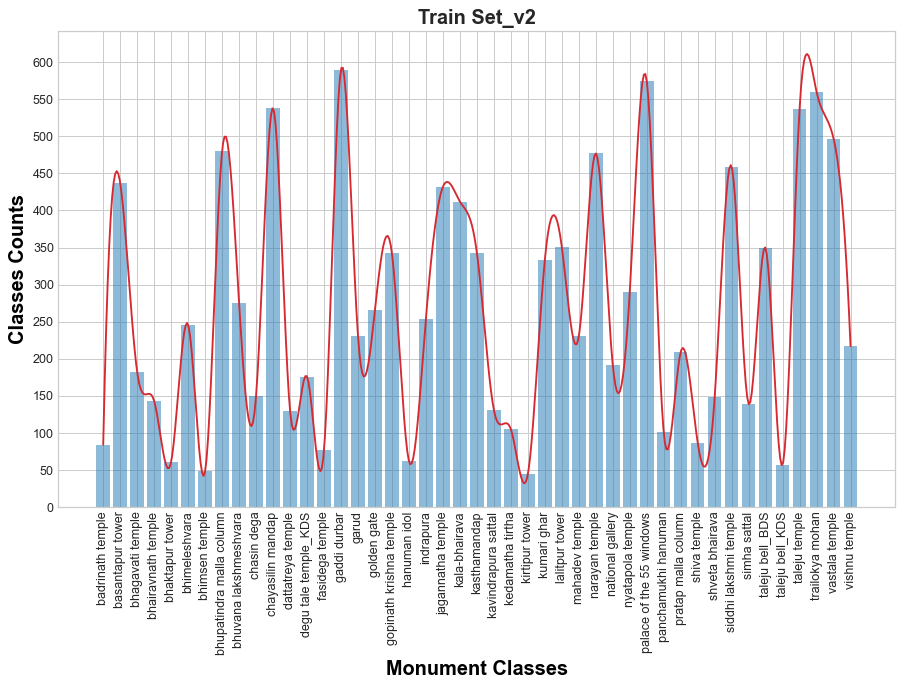

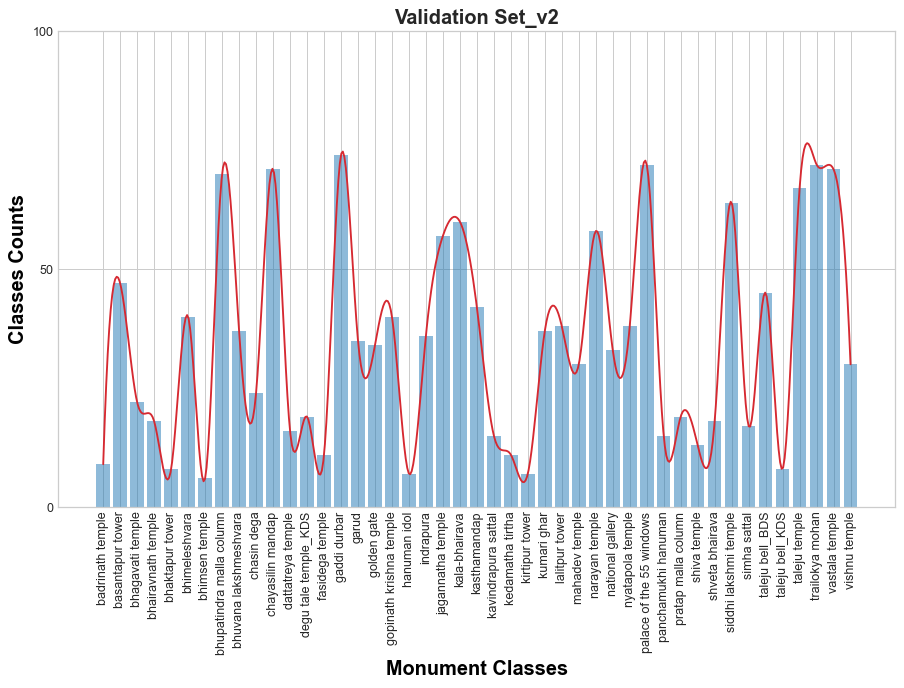

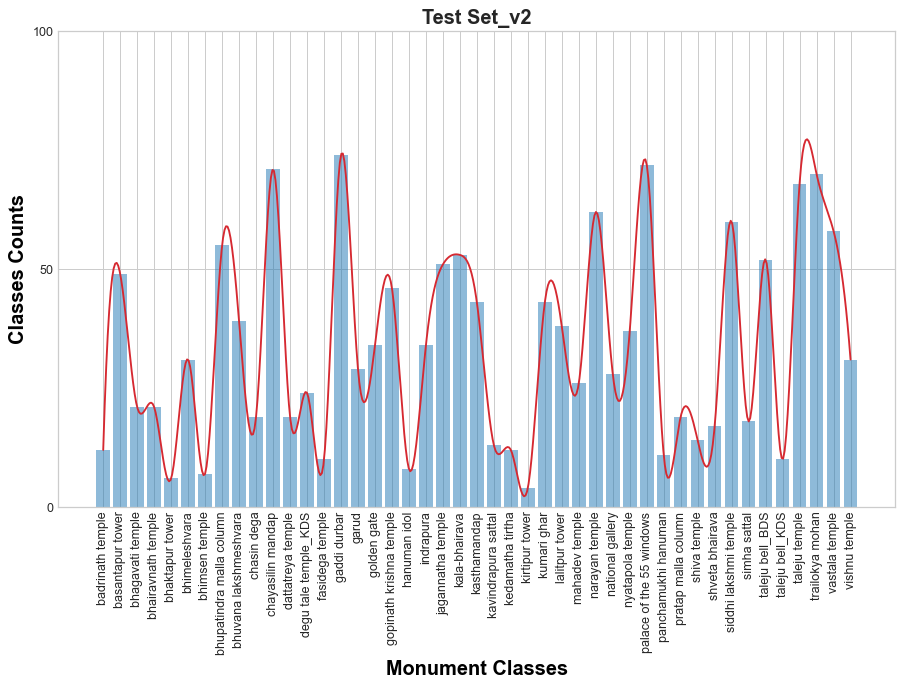

In [15]:
xml_to_bar_chart_for_file(os.path.join(BASE_DIR, annotations_path), train_set_accumulated_list, "Train Set_v2")
xml_to_bar_chart_for_file(os.path.join(BASE_DIR, annotations_path), validation_set_accumulated_list, "Validation Set_v2")
xml_to_bar_chart_for_file(os.path.join(BASE_DIR, annotations_path), test_set_accumulated_list, "Test Set_v2")


In [16]:
colors = ['#d62931', '#7d22dd', "#68fe01", '#0156fe']
sets = [ 'Global', 'Train Set', 'Validation Set', 'Test Set']

In [17]:
def multiple_files_graph(path, accumulated_lists, title_name):
    df_list = list()
    plt.figure(figsize = (14, 7), dpi = 240)
    plt.style.use('seaborn-whitegrid')
    for accumulated_list in accumulated_lists:
        df = file_name_xml_to_df(accumulated_list)
        df_list.append(df)
    colors = ['#d62931', '#7d22dd', "#bc00ff", '#0156fe']
    sets = [ 'Original Set', 'Train Set', 'Validation Set', 'Test Set']
    multiplier = [1, 1, 6, 4]
    index = 0
    for df in df_list:
        class_dict = dict(df.groupby(['class']).count()['class count'].items())
        x_label = list()
        y_label = list()
        max_value = 0
        for key, value in class_dict.items():
            if key not in ignore_list:
                x_label.append(key)
                y_label.append(value)
                max_value = max(max_value, value)
                
        plt.bar(x_label, y_label, width = 0.8, alpha = 0.0)
        x = np.arange(len(x_label))
        X_Y_Spline = make_interp_spline(x, y_label)
        X_ = np.linspace(x.min(), x.max(), 500)
        print(multiplier[index])
        Y_ = X_Y_Spline(X_) * multiplier[index]
        
        plt.plot(X_, Y_, color = colors[index], label = sets[index])
        index += 1
        plt.xticks(rotation = 90)
        plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = True)
        font = {'color': 'black', 'size': 16, 'weight': 'bold'}
        plt.xlabel('Monument Classes', fontdict = font)
        plt.ylabel('', fontdict = font)
        plt.title(title_name, fontdict = {'size': 16, 'weight':'bold'})
    save_loc = os.path.join('Jpgs', title_name + '_with_global.jpg')
    plt.legend(loc = 'upper left')
#     plt.savefig(save_loc, dpi = 240, bbox_inches = 'tight', pad_inches = 0.2)
    plt.show()

1
1
6
4


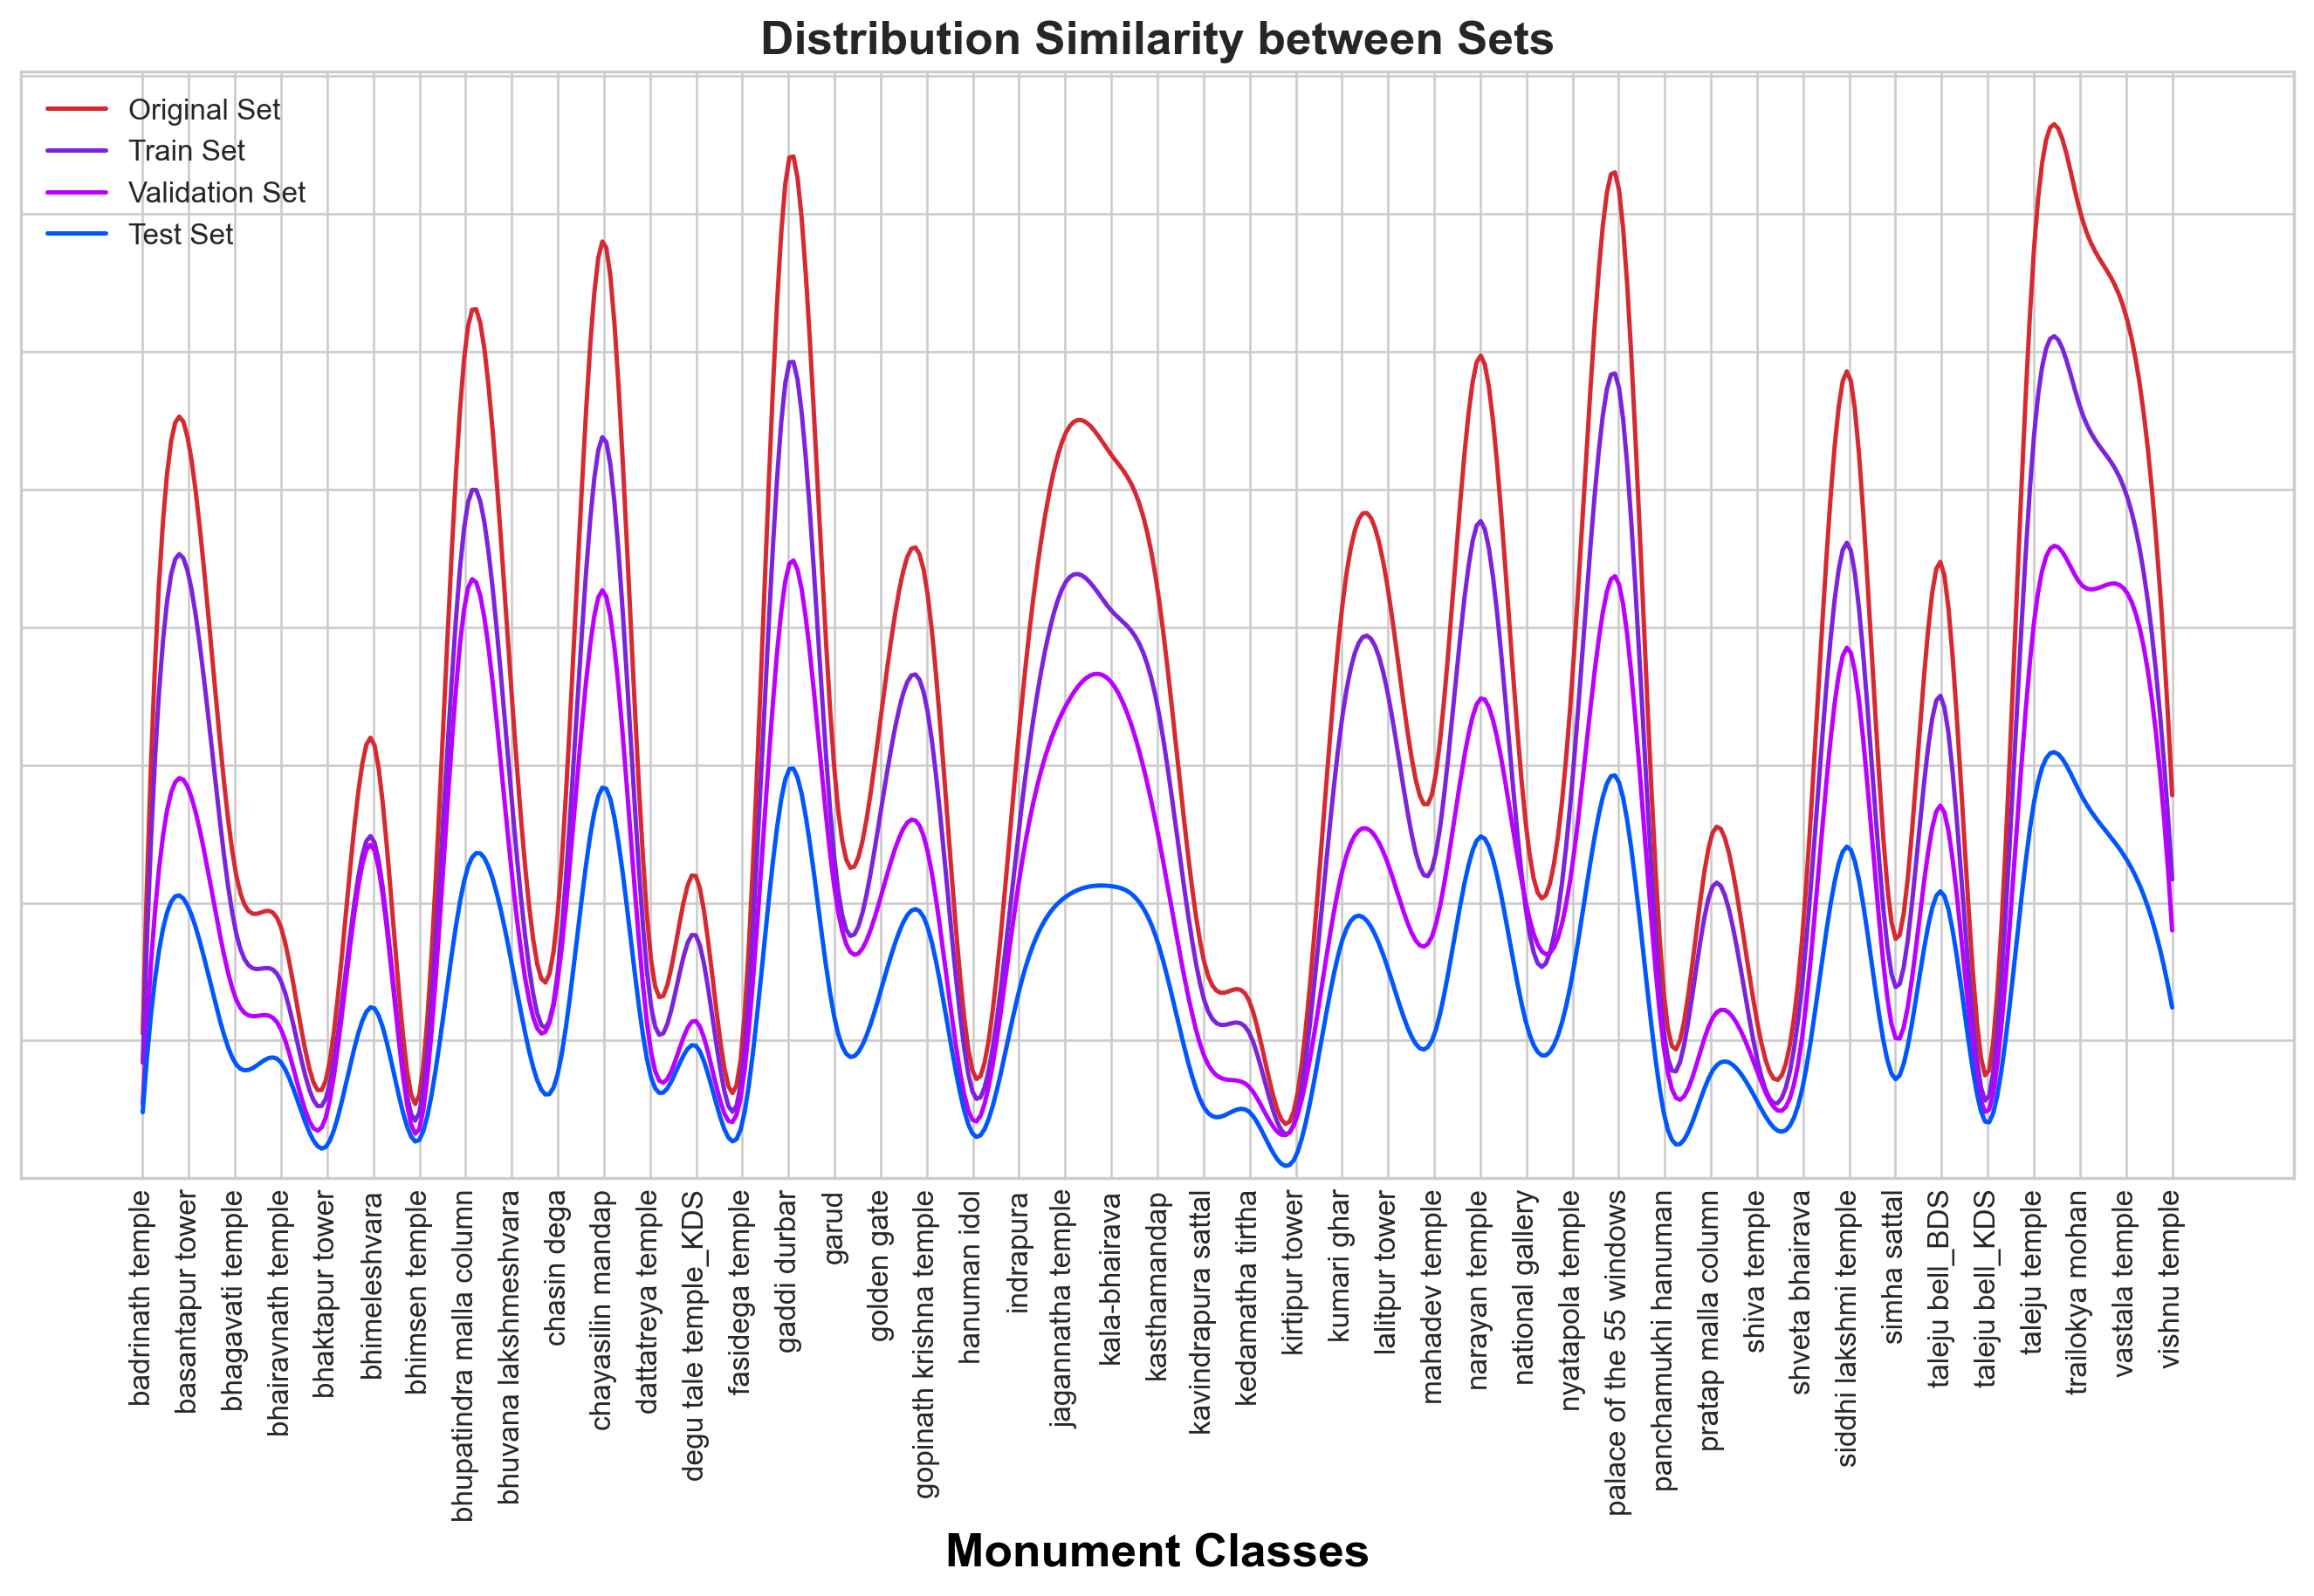

In [18]:
multiple_files_graph(os.path.join(BASE_DIR, annotations_path), [global_accumulated_list, train_set_accumulated_list, validation_set_accumulated_list, test_set_accumulated_list], 'Distribution Similarity between Sets')

In [19]:
def split_into_folder(path, accumulated_list, split_name):
    dest_folder_path = os.path.join(path, split_name)

    if not os.path.exists(dest_folder_path):
        os.mkdir(dest_folder_path)
        os.mkdir(dest_folder_path + '\\Annotations')
        os.mkdir(dest_folder_path + '\\JPEGImages')
        print(dest_folder_path)
        print(os.path.join(dest_folder_path, annotations_path))
        print(os.path.join(dest_folder_path, jpeg_image_path))
    
    for filename in tqdm(accumulated_list):
        src_XML = os.path.join(path, annotations_path, filename + '.xml')
        src_JPG = os.path.join(path, jpeg_image_path, filename + '.jpg')
        dst_XML = os.path.join(dest_folder_path, annotations_path, filename + '.xml')
        dst_JPG = os.path.join(dest_folder_path, jpeg_image_path, filename + '.jpg')
        shutil.copy(src_XML, dst_XML)
        shutil.copy(src_JPG, dst_JPG)

In [20]:
split_into_folder(BASE_DIR, train_set_accumulated_list, 'train')
split_into_folder(BASE_DIR, validation_set_accumulated_list, 'validation')
split_into_folder(BASE_DIR, test_set_accumulated_list, 'test')

F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\train
F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\train\Annotations
F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\train\JPEGImages


100%|██████████████████████████████████████████████████████████████████████████████| 6767/6767 [03:19<00:00, 33.92it/s]


F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\validation
F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\validation\Annotations
F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\validation\JPEGImages


100%|████████████████████████████████████████████████████████████████████████████████| 846/846 [00:22<00:00, 37.64it/s]


F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\test
F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\test\Annotations
F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset\test\JPEGImages


100%|████████████████████████████████████████████████████████████████████████████████| 867/867 [00:22<00:00, 39.05it/s]
